In [1]:
# show more than one output in cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
from torchvision import models as tvm
import pretrainedmodels as ptm
models = (
#     ptm.alexnet, # gets maximum recursion limit exceeded exceptions
    ptm.nasnetalarge, # calculated output size is too small
#     ptm.se_resnet50,
#     ptm.se_resnet101,
#     ptm.inceptionresnetv2,
#     ptm.inceptionv4,
#     ptm.vgg16,
#     ptm.vgg19,
#     tvm.resnet101,
#     ptm.senet154,
)

DATA_DIR = 'data/4_class_11'

domain = [
#     {'name': 'model_num', 'type': 'discrete', 'domain': range(len(models))},
    {'name': 'batch_size', 'type': 'discrete', 'domain': (16, 24, 32, 48, 64)},
    {'name': 'adam_lr', 'type': 'continuous', 'domain': (0.001, 0.1)},
    {'name': 'adam_beta1', 'type': 'continuous', 'domain': (0.8, .99)},
    {'name': 'adam_beta2', 'type': 'continuous', 'domain': (0.95, .9999)},
    {'name': 'adam_wtdecay', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'epochs', 'type': 'discrete', 'domain': (10, 20, 30, 40)}
]
#default_input = [3, 32, 0.001, 0.9, 0.999, 0, 30] # TODO: have to figure out how to do this

In [3]:
import src.utils as utils

model_num = 0

def f(x):
    """ Value function to minimize for bayesian optimization """
    val_acc = train(
        model_num,
        batch_size=int(x[:,0]),
        adam_lr=float(x[:,1]),
        adam_b1=float(x[:,2]),
        adam_b2=float(x[:,3]),
        adam_wtdecay=float(x[:,4]),
        epochs=int(x[:,5])
    )
    
    return -val_acc


NUM_CLASSES = 4


def prepare_model(model_num):
    model_fn = models[model_num]
    if model_fn is tvm.resnet101:
        # torchvision models
        pretrained = True
        last = 'fc'
    else:
        # pretrainedmodels package specific differences
        pretrained = 'imagenet'
        last = 'last_linear'
    image_size = utils.determine_image_size(model_name_from_num(model_num))
    
    model = model_fn(num_classes=1000, pretrained=pretrained)
    num_in = getattr(model, last).in_features
    setattr(model, last, torch.nn.Linear(num_in, NUM_CLASSES))
    return model, image_size

def model_name_from_num(model_num):
    return str(models[model_num]).split()[1]


import os
from train import prepare_results_file

import torch
from torch.optim import Adam
from torch.nn import  CrossEntropyLoss
from src.trainable import Trainable
from src.utils import get_datasets_and_loaders

iteration = 0
def train(model_num, batch_size, adam_lr, adam_b1, adam_b2, adam_wtdecay, epochs):
    global iteration
    iteration += 1
    print("\nITERATION", iteration)
    print(f'model: {str(models[model_num]).split()[1]}, batch_size: {batch_size}, epochs: {epochs}')
    print(f'adam_lr: {adam_lr}, adam_b1: {adam_b1}, adam_b2: {adam_b2}, adam_wtdecay: {adam_wtdecay}')

    model, image_size = prepare_model(model_num)
    
    dataloaders = get_dataloaders(DATA_DIR, ('train', 'val'))
    _, dataloaders = get_datasets_and_loaders(DATA_DIR, 'train', 'val', 
                                              image_size=image_size)
    
    optimizer = Adam(model.parameters(), adam_lr, (adam_b1, adam_b2), adam_wtdecay)
    criterion = CrossEntropyLoss()
    
    trainable = Trainable(model, criterion, optimizer)
    
    params = '_'.join([str(batch_size)] + [f'{param:4f}' for param in (adam_lr, adam_b1, adam_b2, adam_wtdecay)] + [str(epochs)])
    results_fp = os.path.join("experiments", "bayes_opt", model_name_from_num(model_num), os.path.basename(DATA_DIR), params + '.csv')

    prepare_results_file(results_fp)
    try:
        val_acc = trainable.train(dataloaders, epochs, early_stop=5, results_filepath=results_fp, verbose=False)
    except Exception as e:
        if iteration > 1:
            raise e
        print(e)
        val_acc = 0
    return val_acc
    

In [4]:
# # TEST CODE
# train(model, 4, 1e-3, 0.9, 0.999, 0, 50)

## Do BO on all models on both datasets. Git push at each stage

DATA/DIE_VS_ALL_11

ITERATION 1
model: nasnetalarge, batch_size: 64, epochs: 40
adam_lr: 0.08685243254841131, adam_b1: 0.823704459660309, adam_b2: 0.9897171846605224, adam_wtdecay: 0.3675735165519015


Training stopped early at 10 epochs.
Training completed in 23m 15s
Best validation accuracy: 0.8726
Associated train accuracy: 0.8026
Associated train loss: 0.4322

ITERATION 2
model: nasnetalarge, batch_size: 16, epochs: 30
adam_lr: 0.07624192331977708, adam_b1: 0.8541326644005715, adam_b2: 0.9780713437887167, adam_wtdecay: 0.8451001186921837


Training stopped early at 10 epochs.
Training completed in 23m 16s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8715
Associated train loss: 0.2915

ITERATION 3
model: nasnetalarge, batch_size: 32, epochs: 10
adam_lr: 0.09868876358102838, adam_b1: 0.827961682855212, adam_b2: 0.97942299782448, adam_wtdecay: 0.694030065570928


Training stopped early at 10 epochs.
Training completed in 23m 16s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8573
Associated train loss: 0.3566

ITERATION 4
model: nasnetalarge, batch_size: 24, epochs: 10
adam_lr: 0.04736740684090222, adam_b1: 0.8774121931335087, adam_b2: 0.9951958112366829, adam_wtdecay: 0.14396959250530872


Training stopped early at 9 epochs.
Training completed in 20m 57s
Best validation accuracy: 0.9151
Associated train accuracy: 0.7966
Associated train loss: 0.4688

ITERATION 5
model: nasnetalarge, batch_size: 24, epochs: 30
adam_lr: 0.04753880536405214, adam_b1: 0.8306859829443511, adam_b2: 0.9980061056567583, adam_wtdecay: 0.6136448207940522


Training stopped early at 12 epochs.
Training completed in 27m 57s
Best validation accuracy: 0.9151
Associated train accuracy: 0.8836
Associated train loss: 0.2650

ITERATION 6
model: nasnetalarge, batch_size: 24, epochs: 10
adam_lr: 0.001, adam_b1: 0.99, adam_b2: 0.95, adam_wtdecay: 1.0


Training completed in 23m 17s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8300
Associated train loss: 0.3869

ITERATION 7
model: nasnetalarge, batch_size: 24, epochs: 30
adam_lr: 0.09999994426994971, adam_b1: 0.9899996011428103, adam_b2: 0.9500001084332256, adam_wtdecay: 1.3033213180257493e-06


Training stopped early at 6 epochs.
Training completed in 13m 54s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5273
Associated train loss: 15.5603

ITERATION 8
model: nasnetalarge, batch_size: 24, epochs: 10
adam_lr: 0.05136965597017945, adam_b1: 0.8778725271586237, adam_b2: 0.9995160401837255, adam_wtdecay: 0.1459817441081373


Training completed in 23m 17s
Best validation accuracy: 0.8962
Associated train accuracy: 0.7976
Associated train loss: 0.4656

ITERATION 9
model: nasnetalarge, batch_size: 24, epochs: 10
adam_lr: 0.021088830134486092, adam_b1: 0.8743896581382656, adam_b2: 0.9668293970436518, adam_wtdecay: 0.130757910252293


Training stopped early at 8 epochs.
Training completed in 18m 37s
Best validation accuracy: 0.8915
Associated train accuracy: 0.8067
Associated train loss: 0.4532

ITERATION 10
model: nasnetalarge, batch_size: 24, epochs: 30
adam_lr: 0.023737999541605208, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 0.8920544028917317


Training stopped early at 11 epochs.
Training completed in 25m 38s
Best validation accuracy: 0.9057
Associated train accuracy: 0.8563
Associated train loss: 0.3332

ITERATION 11
model: nasnetalarge, batch_size: 24, epochs: 10
adam_lr: 0.1, adam_b1: 0.9545965365505027, adam_b2: 0.9999, adam_wtdecay: 0.5528549107419437


Training stopped early at 10 epochs.
Training completed in 23m 17s
Best validation accuracy: 0.9104
Associated train accuracy: 0.8968
Associated train loss: 0.2609

ITERATION 12
model: nasnetalarge, batch_size: 16, epochs: 30
adam_lr: 0.009265534484135007, adam_b1: 0.9159860527821262, adam_b2: 0.9817114412568977, adam_wtdecay: 0.3226986450689692


Training stopped early at 8 epochs.
Training completed in 18m 37s
Best validation accuracy: 0.9198
Associated train accuracy: 0.8735
Associated train loss: 0.2897

ITERATION 13
model: nasnetalarge, batch_size: 32, epochs: 10
adam_lr: 0.0876575215666159, adam_b1: 0.9324736249192926, adam_b2: 0.9677430495238785, adam_wtdecay: 0.13303204556081377


Training stopped early at 8 epochs.
Training completed in 18m 36s
Best validation accuracy: 0.7358
Associated train accuracy: 0.5992
Associated train loss: 0.6975

ITERATION 14
model: nasnetalarge, batch_size: 32, epochs: 10
adam_lr: 0.001, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 1.0


Training completed in 23m 18s
Best validation accuracy: 0.8538
Associated train accuracy: 0.8340
Associated train loss: 0.4200

ITERATION 15
model: nasnetalarge, batch_size: 16, epochs: 30
adam_lr: 0.1, adam_b1: 0.99, adam_b2: 0.95, adam_wtdecay: 0.5585007693167536


Training stopped early at 12 epochs.
Training completed in 27m 56s
Best validation accuracy: 0.8962
Associated train accuracy: 0.8036
Associated train loss: 0.4492


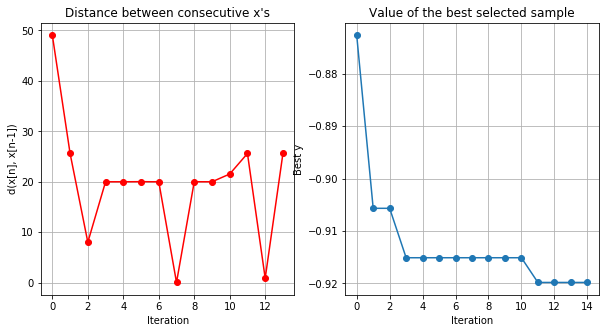

0

0

0

DATA/4_CLASS_11

ITERATION 1
model: nasnetalarge, batch_size: 32, epochs: 40
adam_lr: 0.010428942385613284, adam_b1: 0.959123314728094, adam_b2: 0.9832717340519888, adam_wtdecay: 0.3544479640047351


Training stopped early at 9 epochs.
Training completed in 20m 58s
Best validation accuracy: 0.7689
Associated train accuracy: 0.7733
Associated train loss: 0.5831

ITERATION 2
model: nasnetalarge, batch_size: 24, epochs: 10
adam_lr: 0.045525392664834186, adam_b1: 0.9759191173952316, adam_b2: 0.9536857111093567, adam_wtdecay: 0.3627409119443785


Training completed in 23m 19s
Best validation accuracy: 0.7736
Associated train accuracy: 0.7399
Associated train loss: 0.6739

ITERATION 3
model: nasnetalarge, batch_size: 16, epochs: 20
adam_lr: 0.011566179699215768, adam_b1: 0.8799352966251774, adam_b2: 0.9654053077487723, adam_wtdecay: 0.9224668555350678


Training stopped early at 15 epochs.
Training completed in 34m 58s
Best validation accuracy: 0.7689
Associated train accuracy: 0.8340
Associated train loss: 0.4343

ITERATION 4
model: nasnetalarge, batch_size: 48, epochs: 10
adam_lr: 0.06926802004357922, adam_b1: 0.8824466108118602, adam_b2: 0.951109082065631, adam_wtdecay: 0.9217389903415092


Training stopped early at 8 epochs.
Training completed in 18m 39s
Best validation accuracy: 0.7783
Associated train accuracy: 0.7439
Associated train loss: 0.6965

ITERATION 5
model: nasnetalarge, batch_size: 32, epochs: 10
adam_lr: 0.06961956070987989, adam_b1: 0.8456892286449239, adam_b2: 0.9826159812516215, adam_wtdecay: 0.11473054916587311


Training stopped early at 6 epochs.
Training completed in 13m 57s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5597
Associated train loss: 1.1425

ITERATION 6
model: nasnetalarge, batch_size: 48, epochs: 10
adam_lr: 0.07820900806239817, adam_b1: 0.8088615577588669, adam_b2: 0.9666526440345644, adam_wtdecay: 0.7109160541068249


Training completed in 23m 18s
Best validation accuracy: 0.7594
Associated train accuracy: 0.7571
Associated train loss: 0.6125

ITERATION 7
model: nasnetalarge, batch_size: 16, epochs: 10
adam_lr: 0.06297486925635257, adam_b1: 0.9718189637120225, adam_b2: 0.9687046026228925, adam_wtdecay: 0.3978113070098823


Training stopped early at 9 epochs.
Training completed in 20m 58s
Best validation accuracy: 0.7311
Associated train accuracy: 0.6680
Associated train loss: 0.8520

ITERATION 8
model: nasnetalarge, batch_size: 16, epochs: 20
adam_lr: 0.1, adam_b1: 0.99, adam_b2: 0.9999, adam_wtdecay: 0.0


Training stopped early at 6 epochs.
Training completed in 13m 51s
Best validation accuracy: 0.5660
Associated train accuracy: 0.5678
Associated train loss: nan

ITERATION 9
model: nasnetalarge, batch_size: 24, epochs: 10
adam_lr: 0.1, adam_b1: 0.9150768327714423, adam_b2: 0.9890265495662995, adam_wtdecay: 0.8465060959907049


Training completed in 23m 18s
Best validation accuracy: 0.7972
Associated train accuracy: 0.7429
Associated train loss: 0.6687

ITERATION 10
model: nasnetalarge, batch_size: 32, epochs: 40
adam_lr: 0.1, adam_b1: 0.8, adam_b2: 0.9999, adam_wtdecay: 1.0


Training stopped early at 10 epochs.
Training completed in 23m 19s
Best validation accuracy: 0.7736
Associated train accuracy: 0.7854
Associated train loss: 0.5915

ITERATION 11
model: nasnetalarge, batch_size: 24, epochs: 40
adam_lr: 0.0764222476808491, adam_b1: 0.8955912435553189, adam_b2: 0.9903137168952081, adam_wtdecay: 0.7618102991587533


Training stopped early at 19 epochs.
Training completed in 44m 18s
Best validation accuracy: 0.8019
Associated train accuracy: 0.8077
Associated train loss: 0.5010

ITERATION 12
model: nasnetalarge, batch_size: 24, epochs: 40
adam_lr: 0.008174104369736994, adam_b1: 0.8256887543705496, adam_b2: 0.998928126558818, adam_wtdecay: 0.11606797267813496


Training stopped early at 12 epochs.
Training completed in 27m 59s
Best validation accuracy: 0.8113
Associated train accuracy: 0.7925
Associated train loss: 0.5615

ITERATION 13
model: nasnetalarge, batch_size: 16, epochs: 40
adam_lr: 0.006284271770710701, adam_b1: 0.8711335319996503, adam_b2: 0.9757252262735061, adam_wtdecay: 0.3219147851486027


Training stopped early at 19 epochs.
Training completed in 44m 19s
Best validation accuracy: 0.7925
Associated train accuracy: 0.8553
Associated train loss: 0.3786

ITERATION 14
model: nasnetalarge, batch_size: 16, epochs: 40
adam_lr: 0.1, adam_b1: 0.99, adam_b2: 0.95, adam_wtdecay: 1.0


Training stopped early at 8 epochs.
Training completed in 18m 39s
Best validation accuracy: 0.7075
Associated train accuracy: 0.6852
Associated train loss: 0.8175

ITERATION 15
model: nasnetalarge, batch_size: 24, epochs: 40
adam_lr: 0.1, adam_b1: 0.99, adam_b2: 0.95, adam_wtdecay: 0.3471746154249124


Epoch 17, Train, best val=0.669811:  57%|█████▋    | 564/988 [01:15<00:56,  7.50images/s]

In [ ]:
from GPyOpt.methods import BayesianOptimization
import subprocess
import sys
sys.setrecursionlimit(1500)

for i in range(len(models)):
    model_num = i
    for data_index, datadir in enumerate(('data/die_vs_all_11', 'data/4_class_11')):
        global iteration
        iteration = 0  # reset to 0
        
        DATA_DIR = datadir
        print(datadir.upper())
        NUM_CLASSES = 2 * (data_index+1)
    
        try:
            problem = BayesianOptimization(
                f=f,
                domain=domain
            )
            problem.run_optimization(max_iter=10)
            problem.plot_acquisition()
            problem.plot_convergence()
        
        except Exception as e:
            print('Skipping because', e)
#             import traceback
#             traceback.print_exc()
            continue
            
        # commit & push only if we can connect to internet
        subprocess.check_call(['git', 'add', 'experiments'])
        subprocess.check_call(['git', 'commit', '-am', f'Results from {str(models[i]).split()[1]} {datadir}'])
        subprocess.check_call(['git', 'push'])

In [ ]:
_ = subprocess.check_call(["spd-say", "Your code has finished running"])
_ = subprocess.check_call(['git', 'commit', '-am', "BO final commit"])
_ = subprocess.check_call(['git', 'push'])


In [ ]:
# Run final results

In [ ]:
# models = 
# datasets = ['']

# #     ptm.se_resnet50,
# #     ptm.se_resnet101,
# #     ptm.inceptionresnetv2,
# #     ptm.inceptionv4,
# #     ptm.vgg16,
# #     ptm.vgg19,
# #     tvm.resnet101,
# #     ptm.senet154,

# f'-e final_results -d {dataset} -m se_resnet154 pretrained="imagenet" num_classes=1000 -o Adam lr=0.0074 betas='